# **Práctica 1.2:**
**Análisis del impacto de la pandemia en la salud mental de usuarios de Redes Sociales (Parte II)**

## **Apartado 0:**

En primer lugar debemos **incluir** en este `notebook` todas las librerías que vayamos a utilizar para el desarrollo de la práctica.

In [1]:
import pandas as pd
import numpy as np
from empath import Empath
import dask.dataframe as dd
import multiprocessing
import matplotlib.pyplot as plt
import requests
import time
from datetime import datetime


## **Apartado 1:**

Continuaremos con el análisis de las emociones a lo largo de la pandemia. Para ello en este caso haremos uso de la herramienta de extracción de dimensiones psicológicas latentes en el texto, para lo que utilizaremos la librería [Empath](https://github.com/Ejhfast/empath-client) desarrollada por la Universidad de Stanford.

Es importante antes que nada leer la documentación de esta librería para entender de forma correcta su funcionamiento.

Tras haber leído la documentación que nos proporciona la librería `Empath`, como seguiremos trabajando con el corpus de US data con el trabajamos en la práctica anterior, lo primero será cargar a un objeto del tipo DataFrame el fichero (cabe recordar que en la práctica anterior ya unimos ambos ficheros de datos en un sólo con las columnas con las que debemos trabajar). Para leer el fichero haremos uso, nuevamente, de la función `read_csv`:

In [3]:
path_to_data = 'C:/Users/Andres/Documents/Data/MaBD/datasets/US_data'

df_jan2020_may2021_us_empath = pd.read_csv(
    path_to_data + '/' + 'jan2020_may2021_us.csv',
    usecols=['id', 'username', 'tweet', 'date', 'language'],
    dtype=str
)


Este DataFrame que acabamos de cargar ya sólo cuenta con aquellos tweets que estuviesen escritos en inglés, y fue pre-procesado en la práctica anterior para que no contenga URL's, por lo que no hay que volver a llevar este pre-procesado aquí.

Por lo tanto, lo primero será, a partir de palabras semilla, obtener una serie de subcategorías léxicas más específicas de nuestro dominio concreto, que es el de analizar la salud mental de los usuarios a lo largo de la pandemia. Para esto analizaremos mediante `Empath` cinco categorías léxicas relacionadas con la salud mental de la gente. Las tres primeras son las que se nos proponen en el enunciado de la práctica, **depression**, **anxiety** y **suicide**. A estas tres categorías le añadiremos otras dos a mayores que serán **eating_disorder** y **substance_abuse**. Se escogieron estos dos temas dado que los Trastornos de Conducta Alimentaria (TCA) así como el uso de diferentes drogas también pudieron verse afectados por la evolución de la pandemia y ambos son temas con una clara relación con la salud mental de las personas.

Lo primero es declarar la clase `Empath` que utilizaremos para llevar a cabo el análisis:

In [2]:
lexicon = Empath()


Ahora definiremos las cinco categorías para las cuales vamos a llevar a cabo el análisis. En el *paper* que acompaña a la librería `Empath` dice que lo mejor es hacer uso de entre 2 y 5 palabras semilla (*seed words*) a la hora de crear una nueva categoría para el análisis, por lo que definiremos las categorías con un número de palabras semilla en este rango. Además, `Empath` nos ofrece la posibilidad de trabajar con tres modelos de texto diferentes a la hora de crear las categorías. Estos modelos son *fiction*, *nytimes* y *reddit*. Escogeremos el modelo *reddit* ya que es el que presenta los tipos de textos más cercanos a un tweet.

Por tanto, definimos las **cinco** categorías con las que vamos a trabajar. Para cada una de las cinco categorías `Empath` nos genera un grupo mayor de palabras relacionadas con cada una de las categoría que nosotros hayamos definido:

In [4]:
lexicon.create_category(
    "depression", 
    ["depression", "mood", "adversity", "anguish"], 
    model="reddit"
)


["loneliness", "self-doubt", "hopelessness", "sadness", "anguish", "helplessness", "negative_emotions", "self_hatred", "self-loathing", "self-hatred", "self_loathing", "self_doubt", "emotional_pain", "emotional_turmoil", "powerlessness", "crippling_depression", "overwhelming_feelings", "physical_pain", "anger", "own_depression", "lonliness", "depression", "intense_feelings", "worthlessness", "despondency", "anxieties", "anxiety", "self-hate", "grief", "emotional_stress", "negative_emotion", "inadequacy", "strong_emotions", "mental_anguish", "boredom", "heartbreak", "intense_anxiety", "own_pain", "misery", "anxiousness", "extreme_emotions", "mental_pain", "self-pity", "inner_turmoil", "neurosis", "sorrow", "bad_emotions", "other_emotions", "constant_anxiety", "adversity", "self_hate", "suicidal_depression", "stress", "coping_mechanism", "stressors", "overwhelming_emotions", "conflicting_emotions", "heart_break", "hardships", "dark_thoughts", "bad_feelings", "many_emotions", "emotions", 

In [5]:
lexicon.create_category(
    "anxiety", 
    ["anxiety", "stress", "worry", "fear"], 
    model="reddit"
)


["stress", "anxiety", "anxiety", "worry", "extreme_anxiety", "anxieties", "emotional_stress", "constant_anxiety", "more_anxiety", "anxiousness", "constant_stress", "anxiety_attacks", "stressors", "high_anxiety", "panic_attacks", "crippling_anxiety", "constant_worry", "intense_anxiety", "anxiety_issues", "depression", "intrusive_thoughts", "negative_emotions", "emotional_pain", "serious_anxiety", "stressor", "so_much_stress", "obsessive_thoughts", "suicidal_thoughts", "irrational_thoughts", "physical_pain", "own_anxiety", "such_anxiety", "bad_emotions", "general_anxiety", "terrible_anxiety", "social_anxiety", "daily_stress", "stress/anxiety", "paranoia", "severe_anxiety", "constant_feeling", "so_much_anxiety", "shitty_feelings", "major_anxiety", "anxiety_problems", "loneliness", "work_stress", "anxious_thoughts", "fear", "massive_anxiety", "cope", "anxiety/depression", "coping_mechanism", "negative_thoughts", "restlessness", "great_anxiety", "relieving", "bad_feelings", "self_doubt", "n

In [6]:
lexicon.create_category(
    "suicide", 
    ["suicide", "suicidal", "self_harm", "self_damage", "suicidal_thoughts"], 
    model="reddit"
)


["suicidal_thoughts", "self_harm", "self-harm", "suicidal", "suicidal_ideation", "suicidal_tendencies", "suicidal_feelings", "suicide", "self_injury", "depression", "suicidal_ideations", "severe_depression", "serious_depression", "clinical_depression", "suicide_attempt", "extreme_anxiety", "suicidality", "manic_state", "extreme_depression", "intrusive_thoughts", "depressive_episode", "suicidal_depression", "chronic_depression", "panic_attacks", "suicide_attempts", "mental_health_problems", "suicide", "anxiety", "major_depression", "ptsd", "anxiety_disorder", "mental_health_issues", "even_suicide", "suicidal_thought", "severe_anxiety", "mental_illness", "suicidal_people", "other_mental_health_issues", "psychotic_episode", "depressive_episodes", "psychotic_break", "anxiety_attacks", "constant_anxiety", "severe_mental_illness", "mental_problems", "selfharm", "PTSD", "attempted_suicide", "emotional_pain", "mental_issues", "self-injury", "manic_episode", "BPD", "suicide_thoughts", "untreate

In [7]:
lexicon.create_category(
    "eating_disorder", 
    ["eating_disorder", "anorexia", "obesity", "bulimia"], 
    model="reddit"
)


["anorexia", "bulimia", "eating_disorder", "eating_disorders", "morbid_obesity", "disordered_eating", "anorexia_nervosa", "obesity", "EDNOS", "anorexia", "Anorexia", "overeating", "food_addiction", "body_dysmorphia", "disorders", "EDNOS", "weight_gain", "hypothyroidism", "thyroid_problems", "Anorexia_Nervosa", "diabetes", "anorexics", "weight_problems", "clinical_depression", "anorexic", "PCOS", "poor_diet", "body_image_issues", "disorder", "thyroid_problem", "thyroid_condition", "thyroid_disease", "obese_people", "type_II_diabetes", "thyroid_issues", "depression", "most_obese_people", "major_depression", "weight_problem", "unhealthy_weight", "bad_eating_habits", "high_cholesterol", "overeating", "PCOS", "poor_eating_habits", "bipolar_disorder", "orthorexia", "chronic_depression", "insulin_resistance", "chronic_fatigue", "high_blood_pressure", "real_condition", "other_health_issues", "emotional_eating", "mental_health_problems", "rapid_weight_loss", "health_problems", "severe_depressio

In [8]:
lexicon.create_category(
    "substance_abuse", 
    ["substance_abuse", "addiction", "drugs", "alcoholism"],
    model="reddit"
)


["alcoholism", "drug_addiction", "substance_abuse", "alcohol_abuse", "drug_abuse", "addiction", "addictions", "alcohol_addiction", "drug_use", "heroin_addiction", "self-medication", "self_medication", "drug_addictions", "mental_health_problems", "chemical_dependency", "substance_use", "addiction_problems", "substance_addiction", "drugs/alcohol", "self-medicate", "drugs", "addicts", "opiate_addiction", "mental_illness", "mental_health_issues", "addictive_behavior", "depression", "hard_drugs", "addiction_issues", "self_medicate", "other_addictions", "psychological_problems", "sex_addiction", "excessive_drinking", "Substance_abuse", "marijuana_addiction", "mental_issues", "psychological_issues", "mental_problems", "hard_drug_use", "heroin_use", "mental_illnesses", "severe_mental_illness", "substance_abuse_issues", "other_addiction", "self-harm", "psychosis", "addictive_behaviors", "meth_addiction", "addict", "clinical_depression", "drug_usage", "medicating", "drug_problem", "heroine_addic

Ahora ya podemos llevar a cabo el análisis de nuestro corpus mediante la función `analyze` de la librería `Empath`. Al igual que en la práctica anterior **haremos uso de la librería `Dask`** para llevar a cabo el cálculo de cada uno de estos valores para cada uno de los tweets presentes en el corpus:

In [ ]:
categories = ['depression', 'anxiety', 'suicide', 'eating_disorder', 'substance_abuse']

for category in categories:
    
    # Ejecutamos utilizando la librería Dask para minimizar el tiempo de cómputo
    df_jan2020_may2021_us_empath[category] = dd.from_pandas(
        df_jan2020_may2021_us_empath.tweet,
        npartitions = 4 * multiprocessing.cpu_count()
    ).map_partitions(
        lambda dframe: dframe.apply(
            lambda x: lexicon.analyze(x, categories = [category])[category]
        )
    ).compute(scheduler='processes')


Lo que hace la librería `Empath` es devolvernos e número de palabras en cada uno de los diferentes documentos presentes en nuestro corpus (en nuestro caso particular cada uno de los tweets) que están asociados con cada una de las cinco categorías para las que estamos ejecutando el análisis. Debido a esto, cuanto mayor sea el valor que se nos devuelve para alguna de las categorías, mayor será el nivel de relación de ese tweet con esa categoría. 

Para analizar los resultados lo que haremos será como evolucionan los valores para cada una de las categorías a lo largo de la pandemia.

Al igual que en la práctica guardamos el DataFrame resultante en un nuevo fichero **.csv** para no tener que volver a llevar a cabo el cálculo en el futuro desarrollo de la práctica:

In [11]:
# path_to_data = 'C:/Users/Andres/Documents/Data/MaBD/datasets/US_data'

# # Almacenamos el DataFrame en un fichero .csv
# df_jan2020_may2021_us_empath.to_csv(
#     path_or_buf=path_to_data + '/' + 'jan2020_may2021_us_empath.csv',
#     sep=',',
#     na_rep='',
#     encoding='utf-8',
#     index=False)
    

Para leer el contenido de este fichero ejecutamos la siguiente celda de código (es importante indicarle a la función `read_csv()` que las columnas con los valores resultantes del análisis anterior para cada una de las cinco categorías son `ints`):

In [12]:
# path_to_data = 'C:/Users/Andres/Documents/Data/MaBD/datasets/US_data'

# df_jan2020_may2021_us_empath = pd.read_csv(
#     path_to_data + '/' + 'jan2020_may2021_us_empath.csv',
#     usecols=[
#         'id', 'username', 'tweet', 'date', 'language', 'depression',
#         'anxiety', 'suicide', 'eating_disorder', 'substance_abuse'
#     ],
#     dtype={
#         'id': str, 'username': str, 'tweet': str, 'date': str, 'language': str, 'depression': int,
#         'anxiety': int, 'suicide': int, 'eating_disorder': int, 'substance_abuse': int
#     }
# )


Mostramos algunas filas del DataFrame resultante:

In [33]:
df_jan2020_may2021_us_empath


,id,date,username,tweet,language,depression,anxiety,suicide,eating_disorder,substance_abuse,datetime
0,1417273043513090057,2021-07-20,longasucan2,@jan_forney This NSO Pegasus story needs a dee...,en,0,0,0,0,0,2021-07-20
1,1417273042171015169,2021-07-20,pulsara,Many medics don’t encounter pediatric patients...,en,0,1,0,0,0,2021-07-20
2,1417273042149969923,2021-07-20,hbradio_lv,NOW PLAYING Lil Nas X ( @LILNASX ) - Panini,en,0,0,0,0,0,2021-07-20
3,1417273041936072707,2021-07-20,lightsoutstarr,Carl Froch was and is a top fighting man,en,0,0,0,0,0,2021-07-20
4,1417273040363261954,2021-07-20,chuckwtf,@r8dr4lfe75 I thought Otis was an elevator.,en,0,0,0,0,0,2021-07-20
...,...,...,...,...,...,...,...,...,...,...,...
9622008,1215423075119841280,2020-01-10,bradywalling80,@coach_carroscia bill belichick encourages one...,en,0,0,0,0,0,2020-01-10
9622009,1215423069331681280,2020-01-10,bigshinytyson,"Bread baked. Next stop, homemade tomato-basil ...",en,0,0,0,0,0,2020-01-10
9622010,1215423059529592835,2020-01-10,mirifromwvc,why my dad order me pizza for pick up and ther...,en,0,0,0,0,0,2020-01-10
9622011,1215423025186607105,2020-01-10,nicknewman801,@damienrapp @LatterdayLikes I remember showing...,en,0,0,0,0,0,2020-01-10


## **Apartado 2**

Para llevar a cabo la **representación gráfica de estas dimensiones psicólogicas** descubiertas en el apartado anterior lo que haremos es representar como varía la media de los valores devueltos para cada una de las dimensiones psicólogicas, agrupadas por semanas, a lo largo del tiempo. Igual que en la práctica anterior esto lo haremos para el periodo de tiempo comprendido entre **enero del 2020** y **julio del 2021**.

Probaremos a ver cómo quedan los datos representados mediante esta granularidad temporal. En caso de que no parezca suficientemente precisa, probaremos a representar los datos agrupando con una granularidad más fina, **agrupando por días**. Al igual que para la práctica anterior, descartamos desde un inicio agrupar por meses al ser este un intervalo de tiempo demasiado amplio dentro del cuál se pueden producir cambios bastante bruscos en la salud mental de las personas debido a los eventos ocurridos durante la pandemia.

Para agrupar nuestros datos por semanas, haremos uso de nuevo de la función `resample()` de la librería `pandas`:

In [14]:
# Primero convertimos la columna 'date' de nuestro DataFrame al formato 'datetime'
df_jan2020_may2021_us_empath['datetime'] = pd.to_datetime(df_jan2020_may2021_us_empath.date) - pd.to_timedelta(7, unit='d')

# Agrupamos a nivel de semana, estableciendo el primer día de la semana a lunes (argumento W-MON)
jan2020_may2021_us_empath_by_weeks = df_jan2020_may2021_us_empath.resample(rule='W-MON', on='datetime')


Después de ejecutar la celda de código anterior, ya tenemos los datos del DataFrame con el que estamos trabajando **agrupados por semanas**. Llegados a este punto debemos llevar a cabo la agregación de los valores de cada una de las dimensiones psicológicas con las que estamos trabajando por semanas. En este caso podemos agrupar mediante la **suma** de estos valores o mediante la **media**. Teniendo en cuenta que cuanto mayor sea el valor de una de las dimensiones psicológicas para un tweet, más relación tiene ese tweet con esa dimensión, podemos pensar que en una semana cuanto mayor sea el valor de la suma de los valores de los tweets publicados durante esa semana, mayor será la relación de esa semana con cada una de las cinco dimensiones psicológicas.

Sin embargo, esto haría que para las semanas con un número de tweets mayor los valores devueltos por la agregación también sean mayores (de forma general), por lo tanto obtaremos por utilizar la **media** como forma de agregación.

Por tanto, procedemos a calcular **la media de los valores de cada una de las cinco dimensiones psicológicas** con las que estamos trabajando para cada uno de los tweets que fuesen publicados en cada una de las semanas:

In [15]:
# Calculamos la media de los valores de cada dimensión psicológica para cada semana
df_jan2020_may2021_us_empath_by_weeks = jan2020_may2021_us_empath_by_weeks.agg(
    {
        'depression': 'mean', 
        'anxiety': 'mean', 
        'suicide': 'mean', 
        'eating_disorder': 'mean', 
        'substance_abuse': 'mean'
    }
)


Ahora mostramos por pantalla los primeros valores del DataFrame generado para ver si se ejecutó de forma correcta **la agregación de los valores** para cada dimensión lógica:

In [16]:
# Mostramos las primeras columnas para ver que el cálculo se ejecutó correctamente
df_jan2020_may2021_us_empath_by_weeks.head()


,depression,anxiety,suicide,eating_disorder,substance_abuse
datetime,,,,,
2020-01-06,0.002525,0.005189,0.002837,0.000381,0.001453
2020-01-13,0.002683,0.005065,0.002382,0.000621,0.001702
2020-01-20,0.003481,0.005861,0.002518,0.000747,0.001633
2020-01-27,0.002619,0.004788,0.002091,0.000645,0.001251
2020-02-03,0.002505,0.004754,0.001953,0.000473,0.001460


Como podemos ver, los valores de cada dimensión psicológica fueron agregados de forma correcta. Ahora procemos a la representación gráfica de la evolución de estos cinco valores a lo largo de la pandemia:

Text(0, 0.5, 'Valor medio de cada Dimensión Psicológica')

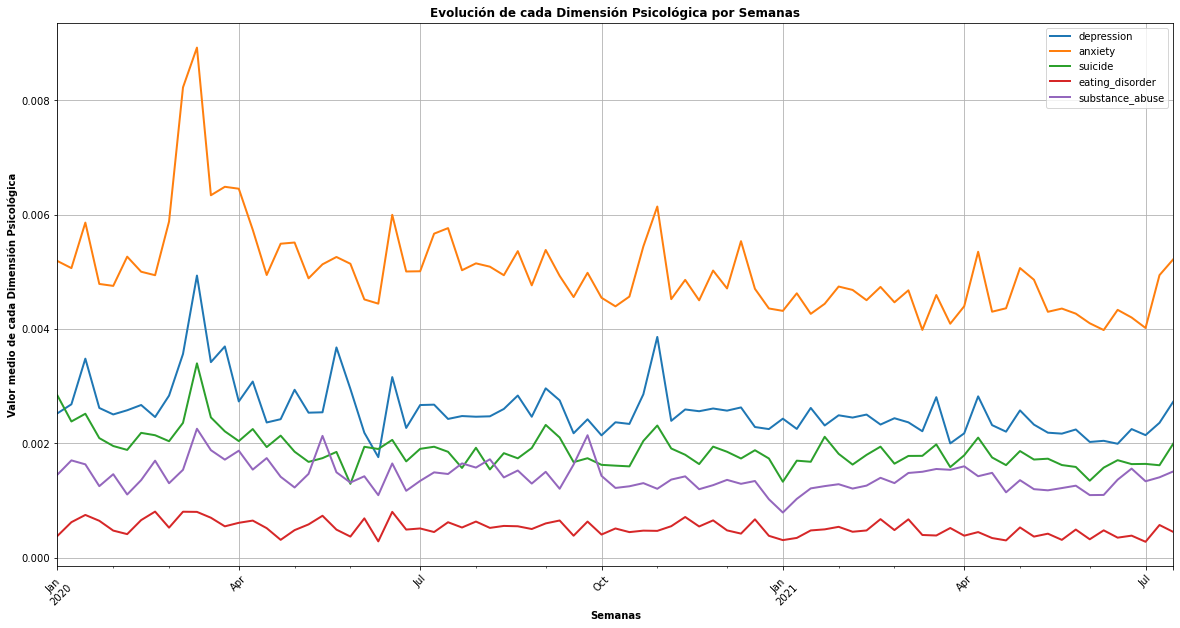

In [17]:
# Graficamos
ax = df_jan2020_may2021_us_empath_by_weeks.plot(
    figsize=(20, 10),
    kind="line",
    rot=45,
    linewidth=2)

ax.grid()

# Añadimos estilo a la gráfica
ax.set_title(
    "Evolución de cada Dimensión Psicológica por Semanas", 
    weight='bold'
)
ax.set_xlabel(
    "Semanas", 
    weight='bold'
)
ax.set_ylabel(
    "Valor medio de cada Dimensión Psicológica", 
    weight='bold'
)


En la gráfica anterior se puede ver que el nivel de detalle aportado al agrupar por semanas es suficiente para sacar conclusiones sobre la evolución de la presencia de estos cinco temas en redes a lo largo de la pandemia. Probaré a **agrupar a nivel de día** para comprobar de forma visual si de esta manera se puede extraer algo más de información del DataFrame con el que trabajamos.

Lo primero será volver a calcular la media de los valores para cada una de las cinco dimensiones psicológicas a nivel de día:

In [18]:
# Primero convertimos la columna 'date' de nuestro DataFrame al formato 'datetime'
df_jan2020_may2021_us_empath['datetime'] = pd.to_datetime(df_jan2020_may2021_us_empath.date)

# Agrupamos a nivel de día
jan2020_may2021_us_empath_by_days = df_jan2020_may2021_us_empath.resample(rule='1D', on='datetime')

# Calculamos la media de los valores para cada día
df_jan2020_may2021_us_empath_by_days = jan2020_may2021_us_empath_by_days.agg(
    {
        'depression': 'mean', 
        'anxiety': 'mean', 
        'suicide': 'mean', 
        'eating_disorder': 'mean', 
        'substance_abuse': 'mean'
    }
)


Ahora volvemos a representar **la evolución de cada una de estas cinco dimensiones psicológicas a lo largo de la pandemia** a nivel de día: 

Text(0, 0.5, 'Valor medio de cada Dimensión Psicológica')

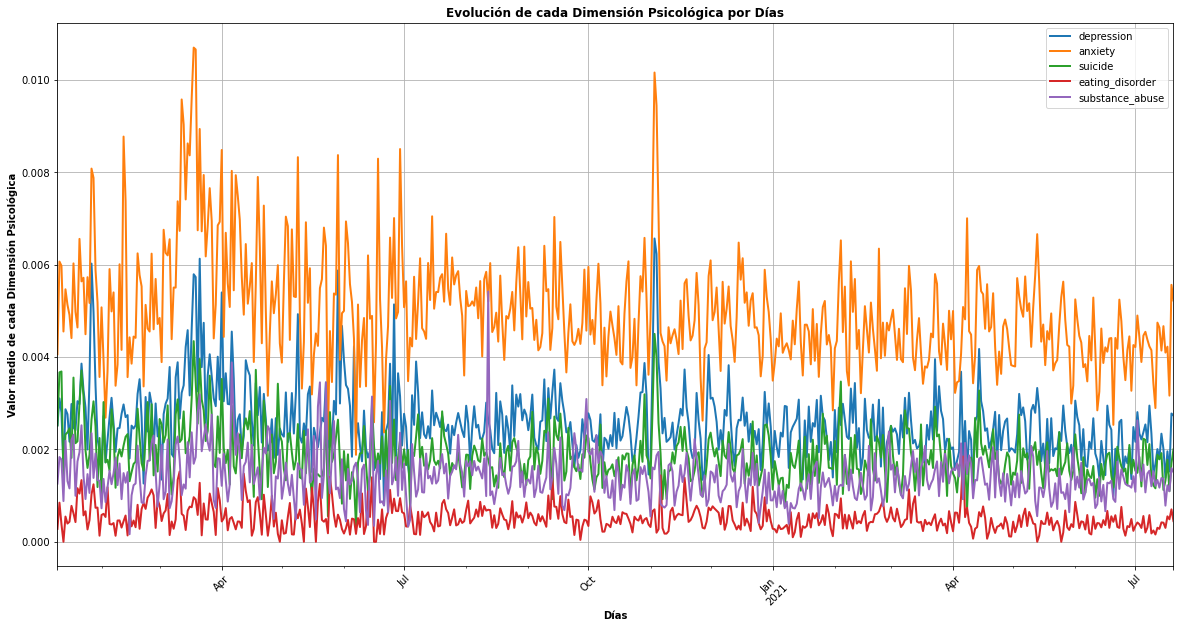

In [19]:
# Graficamos
ax = df_jan2020_may2021_us_empath_by_days.plot(
    figsize=(20, 10),
    kind="line",
    rot=45,
    linewidth=2)

ax.grid()

# Añadimos estilo a la gráfica
ax.set_title(
    "Evolución de cada Dimensión Psicológica por Días", 
    weight='bold'
)
ax.set_xlabel(
    "Días", 
    weight='bold'
)
ax.set_ylabel(
    "Valor medio de cada Dimensión Psicológica", 
    weight='bold'
)


Como se puede ver, la gráfica anterior presenta demasiados cambios bruscos de tendencia que nos impiden extraer información acerca de nuestros datos. Por lo tanto la granularidad a nivel de día es demasiado fina para llevar a cabo la extracción de conclusiones útiles.

Probaremos por último a graficar mediante **el suavizado del valor medio para cada una de las dimensiones psicológicas**, calculando este valor suavizado como la media del valor de cada día junto con el de los seis días previos.

Para suavizar el valor diario de cada dimensión psicológico debemos en primer lugar procesar el DataFrame anterior:

In [20]:
categories = ['depression', 'anxiety', 'suicide', 'eating_disorder', 'substance_abuse']

# Suavizamos el valor del cada dimensión psicológica
for category in categories:
    df_jan2020_may2021_us_empath_by_days[f"smooth_{category}"] = df_jan2020_may2021_us_empath_by_days[category].rolling(7).mean()
    df_jan2020_may2021_us_empath_by_days[f"smooth_{category}"].fillna(df_jan2020_may2021_us_empath_by_days[category], inplace=True)


Tras llevar a cabo este procesado,**mostramos la gráfica de evolución de cada una de nuestras cinco dimensiones psicológicas** en Estados Unidos durante la pandemia:

Text(0, 0.5, 'Valor medio de cada Dimensión Psicológica')

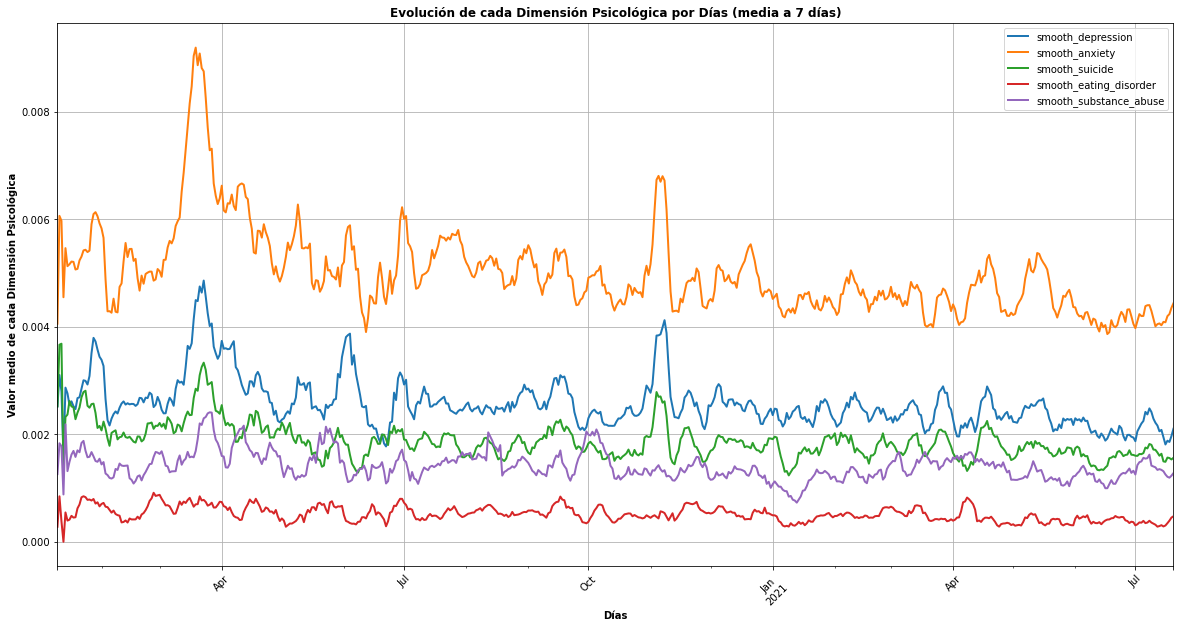

In [21]:
# Graficamos
ax = df_jan2020_may2021_us_empath_by_days[
    [
        'smooth_depression',
        'smooth_anxiety',
        'smooth_suicide',
        'smooth_eating_disorder',
        'smooth_substance_abuse' 
    ]
].plot(
    figsize=(20, 10),
    kind="line",
    rot=45,
    linewidth=2)

ax.grid()

# Añadimos estilo a la gráfica
ax.set_title(
    "Evolución de cada Dimensión Psicológica por Días (media a 7 días)", 
    weight='bold'
)
ax.set_xlabel(
    "Días", 
    weight='bold'
)
ax.set_ylabel(
    "Valor medio de cada Dimensión Psicológica", 
    weight='bold'
)


Con el valor suavizado a 7 días se alcanza un buen punto intermedio entre la generalidad excesiva de la representación por semanas y los cambios demasiado bruscos en la tendencia al representar a nivel de día. Por tanto, **utilizaremos esta última gráfica** para sacar nuestras conclusiones al juntarla con la curva de contagios.

Para obtener los datos sobre los contagios a lo largo de la pandemia usaremos de nuevo el dataset descargo de [https://covid.cdc.gov/covid-data-tracker/#trends_dailycases](https://covid.cdc.gov/covid-data-tracker/#trends_dailycases) con los datos sobre el número de contagios diarios en Estados Unidos durante la pandemia para añadir a nuestra gráfica anterior **la curva con la incidencia acumulada a 7 días** (*7-Day Moving Avg* en el dataset).

Para esto, lo primero será cargar los datos del fichero **.csv** y pre-procesar este DataFrame para que tenga el formato adecuado para que podamos llevar a cabo la representación que buscamos:

In [22]:
df_daily_case_trends_us = pd.read_csv(
    path_to_data + '/' + 'data_table_for_daily_case_trends__the_united_states.csv',
    usecols=['Date','7-Day Moving Avg'],
    dtype={'Date': str, '7-Day Moving Avg': int}
)

# Formateamos el DataFrame con los datos sobre los casos de covid
df_daily_case_trends_us['datetime'] = pd.to_datetime(df_daily_case_trends_us['Date'])
df_daily_case_trends_us.drop(columns='Date', inplace=True)
df_daily_case_trends_us.set_index('datetime', inplace=True)
df_daily_case_trends_us.sort_index(inplace=True)


Después de haber cargado los datos, eliminamos de este nuevo DataFrame, como del DataFrame con los datos de la evolución de cada una de las cinco dimensiones psicológicas por días, los días para los cuales **no tenemos información** para todas las variables que queremos representar.

Esto lo hacemos a continuación:

In [23]:
# Definimos el primer y el último día para el que tenemos datos de sentimientos y de covid
start_date = max(df_jan2020_may2021_us_empath_by_days.first_valid_index(), df_daily_case_trends_us.first_valid_index())
end_date = min(df_jan2020_may2021_us_empath_by_days.last_valid_index(), df_daily_case_trends_us.last_valid_index())

# Eliminamos los días que queden fuera de este rango
df_jan2020_may2021_us_empath_by_days = df_jan2020_may2021_us_empath_by_days[df_jan2020_may2021_us_empath_by_days.index >= start_date]
df_jan2020_may2021_us_empath_by_days = df_jan2020_may2021_us_empath_by_days[df_jan2020_may2021_us_empath_by_days.index <= end_date]
df_daily_case_trends_us = df_daily_case_trends_us[df_daily_case_trends_us.index >= start_date]
df_daily_case_trends_us = df_daily_case_trends_us[df_daily_case_trends_us.index <= end_date]


Finalmente, mostramos la gráfica que muestra **la evolución de las cinco dimensiones psicológicas a lo largo de la pandemia junto con la incidencia acumulada a 7 días**:

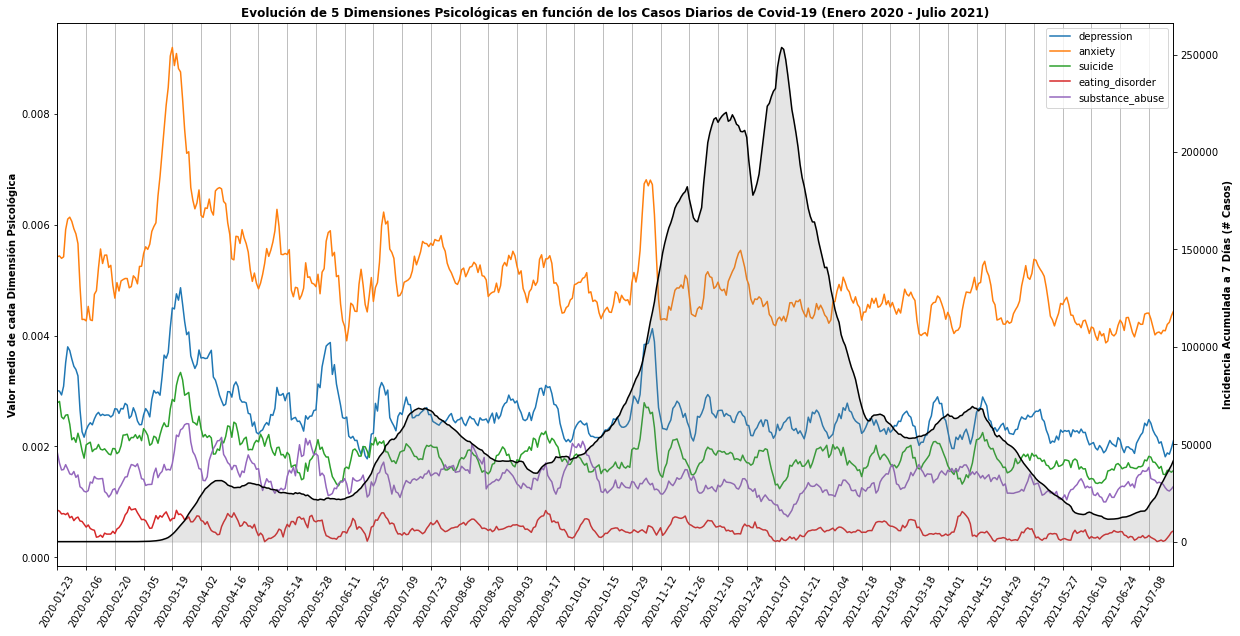

In [24]:
def grap_dimensions_and_covid():
    # Definimos el número de días a representar
    n_days = df_jan2020_may2021_us_empath_by_days.shape[0]

    # Definimos los valores que queremos representar en cada eje
    x = np.arange(0, n_days, 1)
    y_ax1 = df_jan2020_may2021_us_empath_by_days[
        [
            'smooth_depression',
            'smooth_anxiety',
            'smooth_suicide',
            'smooth_eating_disorder',
            'smooth_substance_abuse'
        ]
    ]
    y_ax2 = df_daily_case_trends_us['7-Day Moving Avg']

    # Representamos los datos de sentimientos
    fig, ax1 = plt.subplots(figsize=(20, 10))
    ax1.plot(x, y_ax1)
    ax1.legend(
        [
            'depression', 
            'anxiety', 
            'suicide',
            'eating_disorder', 
            'substance_abuse'
        ], 
        loc='upper right')
    ax1.xaxis.grid(True)
    ax1.set_xlim(x.min(), x.max())

    # Definimos los xticks a representar
    xticks = np.arange(0, n_days, 14)
    xticks_labels = df_jan2020_may2021_us_empath_by_days.index.astype(str).to_frame().iloc[xticks]

    # Añadimos estilo al eje x
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xticks_labels.datetime, rotation=60)

    # Instanciamos un segundo ax que comparte el eje x con el anterior
    ax2 = ax1.twinx()

    # Representamos los datos de covid
    ax2.plot(x, y_ax2, color='black')
    ax2.fill_between(x, y_ax2, color='gray', alpha=0.2)

    # Añadimos texto a la gráfica
    ax1.set_title(
        'Evolución de 5 Dimensiones Psicológicas en función de los Casos Diarios de Covid-19 (Enero 2020 - Julio 2021)',
        weight='bold'
    )
    ax1.set_ylabel(
        'Valor medio de cada Dimensión Psicológica',
        weight='bold'
    )
    ax2.set_ylabel(
        'Incidencia Acumulada a 7 Días (# Casos)',
        weight='bold'
    )

grap_dimensions_and_covid()


Ahora podemos sacar conclusiones sobre los datos que hemos obtenido a partir del estudio realizado en los apartados anteriores. En primer lugar, hablaré sobre la evolución entre Enero de 2020 y Julio de 2021 de los valores medios para cada una de las cinca dimensiones psicológicas para las cuáles estamos llevando a cabo el estudio. Estas cinco dimensiones psicológicas son **la depresión**, **la ansiedad**, **el suicidio**, **los trastornos de la conducta alimentaria** y **el abuso de sustancias**.

Como se puede ver en la gráfica superior, a lo largo de toda la pandemia la prevalencia de unos temas sobre otros se mantiene estable. El tema del que más se habla a lo largo de la pandemia es la ansiedad con bastante margen de diferencia sobre la segunda categoría de la que más se habla, que es la depresión. En tercer lugar estaría el suicidio, en cuarto lugar estaría el abuso de sustancias y en último lugar a lo largo de todo nuestro periodo estarían los trastornos de la conducta alimentaria.

Podemos notar como si que hay ciertos momentos a lo largo de la pandemia, como pueden ser las semanas entre el 14-05-2020 y el 28-05-2020, donde el abuso de sustancias supera al suicido en su presencia en los tweets de la gente. Quitando estos breves periodos de tiempo en los que estas dos categorías intercambia su posición de importancia, el orden de las categorías se mantiene estable durante los 18 meses que dura nuestro estudio.

Podemos ver como también hay una relación bastante clara entre el aumento de todas las dimensiones psicológicas, con dos picos bastante claros en los que los valores para las cinco categorías que estamos estudiando aumenta drásticamente. Estos picos se producen alredor del 19-03-2020; y entre el 29-10-2020 y el 12-11-2020.

Tras el pico inicial del 19-03-2020 los valores para la ansiedad tienden a ir decreciendo ligeramente a lo largo del resto de la pandemia, mientras que para las otras cuatro dimensiones se mantienen más o menos estables, sobre todo para el caso los trastornos de la conducta alimentaria, para la cual vemos bastante poca variación a lo largo de los meses.

Ahora trataremos de asociar los cambios en los valores de las cinco dimensiones psicológicas con los casos de Covid-19. Para esto nos ayudaremos también de la web [https://www.ajmc.com/view/a-timeline-of-covid19-developments-in-2020](https://www.ajmc.com/view/a-timeline-of-covid19-developments-in-2020) que nos proporciona información a mayores sobre eventos relevantes de la pandemia sucedidos en Estados Unidos.

Como se puede ver en la gráfica tanto el primer pico en el aumento de los valores para las distintas dimensiones, como el segundo, se corresponden con aumentos bastante considerables en el número de casos de Covid. El primero de los picos también se corresponde además con la de claración, por parte del gobierno de Estados Unidos, del estado de emergencia. Por otra parte, el segundo pico se corresponde con el pico máximo en el número de casos.

Quitando estos dos eventos importantes, parece que el estado del coronavirus no afectó mucho más en la salud mental de la gente. Esto se podría explicar porque Estados Unidos fue un país con un menor número de restricciones que otros países y también uno de los primeros en los que empezó la campaña de vacunación.

## **Apartados 3 y 4**

Ahora vamos a realizar un nuevo análisis adicional con una colección de datos extraídos de Reddit. En este apartado es necesario limitar los posts al periodo que nos interesa, es decir, al periodo entre Enero de 2020 y Julio de 2021.

Como ninguna de las dos librerías propuestas en el enunciado nos da la opción de filtrar por fecha, pero se nos da la opción de utilizar alguna herramienta de terceros, tras una búsqueda de si existe alguna herramienta que sí nos permita filtra por un rango de fechas, haremos uso de la API Web de [PushShift](https://github.com/pushshift/api).

Esta fue la opción encontrado que más sencilla parecía de utilizar y que ofrecía tanto la opción de obtener comentarios de Reddit dentro de un rango de tiempo específico, como de obtener comentarios de un subreddit específico. Además, esta API web se puede utilizar sin necesidad de autentificarse, por lo que su uso es aún más sencillo que el de otras opciones como [PRAW](https://github.com/praw-dev/praw).

Lo primero, por tanto será usar esta API para obtener un conjunto de comentarios de Reddit con los que poder ejecutar el análisis de las dimenesiones psicológicas. Empezaremos por definir una función que nos permita hacer consultas contra la API y nos devuelva el JSON con la respuesta:

In [34]:
def get_pushshift_data(data_type, **kwargs):
    """
    Gets data from the PushShift API.
 
    data_type can be 'comment' or 'submission'
 
    Read more: https://github.com/pushshift/api
    """

    base_url = f"https://api.pushshift.io/reddit/search/{data_type}/"
    request = requests.get(base_url, params=kwargs)
    return request.json()
    

Leyendo la documentación de esta API, podemos ver como podemos especificar un rango en el que buscará los comentarios. Estos parámetros debemos pasarselos a la consulta como un valor epoch, por lo que definimos una función que nos pase una fecha en formato yyyy-MM-dd al valor correspondiente en epoch:

In [35]:
def timestamp_to_epoch(timestamp: str):
    return int((datetime.strptime(timestamp, "%d-%m-%Y") - datetime(1970, 1, 1)).total_seconds())


A continuación definimos una búsqueda de prueba en el subreddit **r/askscience** entre el 01-01-2020 y el 02-01-2020 para comprobar que todo funcione correctamente:

In [36]:
data = get_pushshift_data(
    data_type = 'comment',
    subreddit='askscience',
    after = timestamp_to_epoch('01-01-2020'),
    before = timestamp_to_epoch('02-01-2020'),
    size = 1
)

print(data)


{'data': [{'all_awardings': [], 'associated_award': None, 'author': 'burbur90', 'author_flair_background_color': None, 'author_flair_css_class': None, 'author_flair_richtext': [], 'author_flair_template_id': None, 'author_flair_text': None, 'author_flair_text_color': None, 'author_flair_type': 'text', 'author_fullname': 't2_cx2np', 'author_patreon_flair': False, 'author_premium': False, 'awarders': [], 'body': "This is partially true, but the arms of a modern bow are also more efficient springs, and the duration of the arrow's acceleration is better with the compound. Much like how an old 800lb crossbow delivers less energy than a 160lb longbow. Tod's Workshop on YouTube has a great video about this", 'collapsed_because_crowd_control': None, 'created_utc': 1577836835, 'gildings': {}, 'id': 'fconqhr', 'is_submitter': False, 'link_id': 't3_ei0z8c', 'locked': False, 'no_follow': True, 'parent_id': 't1_fcoc93i', 'permalink': '/r/askscience/comments/ei0z8c/how_exactly_did_knights_in_full_su

Como podemos comprobar, lo que esta función nos devuelve es un objeto JSON con una lista llamada `data` con todos los comentarios encontrados. Nosotros sin embargo, no necesitamos toda esta información, por lo que definimos una función que nos devuelva un objeto de tipo `dict` con la información que queremos almacenar. Esta información será el **autor del comentario**, el **subreddit en el que se publicó**, el **cuerpo del comentario** y la **fecha de publicación de este comentario**. Esto lo hacemos en la siguiente función:

In [37]:
def pushshift_response_to_dict(pushshift_response:dict):
    output = {'comments': []}

    for comment in pushshift_response['data']:
        # Filtramos los comentarios que hayan sido eliminados
        if(comment['body'] != '[removed]' and comment['body'] != '[deleted]'):
            output['comments'].append(
                {
                    'author': comment['author'],
                    'subreddit': comment['subreddit'],
                    'body': comment['body'],
                    'created_utc': comment['created_utc']
                }
            )
    
    return output


Finalmente, como esta API tiene un limite de comentarios a obtener menor o igual a 500 lo que haremos es generar una función que nos genere intervalos de una dada duración de un intervalo de tiempo para poder ejecutar en un bucle la obtención de comentarios de un determinado subreddit para cada uno de estos intervalos generados. Esto lo hacemos en la siguiente función:

In [38]:
def get_intervals(start_at, end_at, number_of_days_per_interval = 1): 
    intervals = []

    # 1 día = 86400 segundos
    period = (86400 * number_of_days_per_interval)
    end = start_at + period
    
    intervals.append((int(start_at), int(end)))

    while end <= end_at:
        start_at = end + 1
        end = (start_at - 1) + period
        intervals.append((int(start_at), int(end)))
    
    return intervals
    

Por último juntamos todo este código en una sóla celda de código en la que obtengamos los comentarios para el periodo de tiempo con el que estamos trabajando e intentando que los comentarios obtenidos estuviesen centrados en Estados Unidos, para esto lo que haremos será primero definir una lista con todos los subreddits de las **ciudades más pobladas** de Estados Unidos así como de sus **estados más poblados**. Obviamente se pueden introducir falsos positivos en nuestra búsqueda ya que un usuario de Reddit de cualquier país puede comentar en estos subreddits, sin embargo, la probabilidad de que la gente comentando en subreddits sobre ciudades de Estados Unidos sea la propia gente que vive en estas ciudades, o por lo menos que las haya visitado, es lo más probable. Lo mismo se aplica para los diferentes estados.

Por lo tanto, definimos la lista de los subreddits a consultar: 

In [39]:
cities = [
    'nyc', 'seattle', 'losangeles', 'chicago', 'austin', 'portland', 'sanfrancisco',
    'boston', 'houston', 'atlanta', 'philadelphia', 'denver', 'dallas', 'washingtondc', 
    'sandiego', 'pittsburgh', 'phoenix', 'minneapolis', 'orlando', 'nashville', 'stlouis'
]
states = [
    'texas', 'california', 'newjersey', 'michigan', 'minnesota', 'colorado', 'wisconsin',
    'florida', 'connecticut', 'oregon', 'ohio', 'hawaii', 'northcarolina', 'oklahoma',
    'maryland', 'arizona', 'virginia', 'iowa', 'maine', 'indiana', 'georgia', 'alaska'
]

# Juntamos ambas listas en una única lista
subreddits = cities + states


Y ejecutamos la obtención de los comentarios de Reddit:

In [ ]:
comments = []
for subreddit in subreddits:
    # Definimos los intervalos que vamos a usar
    intervals = get_intervals(timestamp_to_epoch('23-01-2020'), timestamp_to_epoch('22-07-2021'), 7)

    for interval in intervals:
        try:
            data = get_pushshift_data(
                data_type = 'comment',
                subreddit = subreddit,
                after = interval[0],
                before = interval[1],
                size = 500
            )
            time.sleep(.5)

            data = pushshift_response_to_dict(data)
            comments.extend(data['comments'])
        except:
            print("Error")

# Convertimos el resultado a un objeto del tipo DataFrame
df_jan2020_jul2021_us_reddit = pd.DataFrame(comments)


Escribimos el DataFrame obtenido a un fichero para que pueda ser utilizado más adelante sin la necesidad de volver a obtener todos los comentarios de Reddit. Esto lo hacemos mediante el siguiente código:

In [41]:
# path_to_data = 'C:/Users/Andres/Documents/Data/MaBD/datasets/US_data'

# # Almacenamos el DataFrame en un fichero .csv
# df_jan2020_jul2021_us_reddit.to_csv(
#     path_or_buf = path_to_data + '/' + 'jan2020_jul2021_us_reddit.csv',
#     sep = ',',
#     na_rep = '',
#     encoding = 'utf-8',
#     index = False
# )


Y leeríamos el dataset mediante el siguiente código:

In [53]:
# path_to_data = 'C:/Users/Andres/Documents/Data/MaBD/datasets/US_data'

# df_jan2020_jul2021_us_reddit = pd.read_csv(
#     path_to_data + '/' + 'jan2020_jul2021_us_reddit.csv',
#     usecols = ['author', 'subreddit', 'body', 'created_utc'],
#     dtype = {'author:': str, 'subreddit': str, 'body': str, 'created_utc': int}
# )


Comprobamos que el DataFrame se ha leído correctamente del fichero **.csv**:

In [54]:
df_jan2020_jul2021_us_reddit[['author', 'subreddit', 'body', 'created_utc']]


,author,subreddit,body,created_utc
0,a_green_orange,nyc,I don't like totally graffitti-covered trains ...,1579737601
1,kantu5,nyc,Fucking hell,1579737638
2,nycnola,nyc,Yes.,1579737731
3,usaman123456,nyc,"ok. given that part of our history, do you rea...",1579737739
4,drpvn,nyc,Hopefully this will crash and burn like last y...,1579737795
...,...,...,...,...
194989,PubeMonger5,Colorado,That 'Scante!,1607631528
194990,Hullabaloooooooo,Colorado,Grass-fed cacao. You can see the cacaos from t...,1607631684
194991,CMWalsh88,Colorado,Only in Boulder County would someone try to ma...,1607633139
194992,CMWalsh88,Colorado,An administration of guilt along with the ingr...,1607633673


Como se puede observar, **obtenemos 194.994 comentarios de Reddit**, con los que trabajaremos a continuación. Si redujésemos el número de días en cada uno de nuestros intervalos de búsqueda podríamos obtener un número de comentarios mayor.

Llevaremos ahora un análisis de las cinco dimensiones piscológicas con este nuevo DataFrame de la misma manera que lo hicimos en los apartados anteriores. El código es muy similar al ya explicado con anterioridad por lo que no se entrará en mucho detalle en este caso. En primer lugar, volvemos a crear las categorías para el análisis:

In [44]:
%%capture

lexicon = Empath()

lexicon.create_category(
    "depression", 
    ["depression", "mood", "adversity", "anguish"], 
    model="reddit"
)

lexicon.create_category(
    "anxiety", 
    ["anxiety", "stress", "worry", "fear"], 
    model="reddit"
)

lexicon.create_category(
    "suicide", 
    ["suicide", "suicidal", "self_harm", "self_damage", "suicidal_thoughts"], 
    model="reddit"
)

lexicon.create_category(
    "eating_disorder", 
    ["eating_disorder", "anorexia", "obesity", "bulimia"], 
    model="reddit"
)

lexicon.create_category(
    "substance_abuse", 
    ["substance_abuse", "addiction", "drugs", "alcoholism"],
    model="reddit"
)


Lo siguiente es llevar a cabo el análisis de nuestro nuevo corpus:

In [45]:
categories = ['depression', 'anxiety', 'suicide', 'eating_disorder', 'substance_abuse']

for category in categories:
    
    # Ejecutamos utilizando la librería Dask para minimizar el tiempo de cómputo
    df_jan2020_jul2021_us_reddit[category] = dd.from_pandas(
        df_jan2020_jul2021_us_reddit.body,
        npartitions = 4 * multiprocessing.cpu_count()
    ).map_partitions(
        lambda dframe: dframe.apply(
            lambda x: lexicon.analyze(str(x), categories = [category])[category]
        )
    ).compute(scheduler='processes')


Escribimos a un fichero **.csv** para no tener que volver a ejecutar este cálculo en el futuro:

In [46]:
# path_to_data = 'C:/Users/Andres/Documents/Data/MaBD/datasets/US_data'

# # Almacenamos el DataFrame en un fichero .csv
# df_jan2020_jul2021_us_reddit.to_csv(
#     path_or_buf=path_to_data + '/' + 'jan2020_jul2021_us_reddit.csv',
#     sep=',',
#     na_rep='',
#     encoding='utf-8',
#     index=False
# )


Para leer este fichero y cargar el DataFrame usamos la función `read_csv()` de la librería `pandas`:

In [55]:
# path_to_data = 'C:/Users/Andres/Documents/Data/MaBD/datasets/US_data'

# df_jan2020_jul2021_us_reddit = pd.read_csv(
#     path_to_data + '/' + 'jan2020_jul2021_us_reddit.csv',
#     usecols=[
#         'author', 'subreddit', 'body', 'created_utc', 'depression',
#         'anxiety', 'suicide', 'eating_disorder', 'substance_abuse'
#     ],
#     dtype={
#         'author': str, 'subreddit': str, 'body':str, 'created_utc':int, 'depression': int,
#         'anxiety': int, 'suicide': int, 'eating_disorder': int, 'substance_abuse': int
#     }
# )


Mostramos algunas filas del DataFrame resultante:

In [56]:
df_jan2020_jul2021_us_reddit


,author,subreddit,body,created_utc,depression,anxiety,suicide,eating_disorder,substance_abuse
0,a_green_orange,nyc,I don't like totally graffitti-covered trains ...,1579737601,0,0,0,0,0
1,kantu5,nyc,Fucking hell,1579737638,0,0,0,0,0
2,nycnola,nyc,Yes.,1579737731,0,0,0,0,0
3,usaman123456,nyc,"ok. given that part of our history, do you rea...",1579737739,0,0,0,0,0
4,drpvn,nyc,Hopefully this will crash and burn like last y...,1579737795,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
194989,PubeMonger5,Colorado,That 'Scante!,1607631528,0,0,0,0,0
194990,Hullabaloooooooo,Colorado,Grass-fed cacao. You can see the cacaos from t...,1607631684,0,0,0,0,0
194991,CMWalsh88,Colorado,Only in Boulder County would someone try to ma...,1607633139,0,0,0,0,0
194992,CMWalsh88,Colorado,An administration of guilt along with the ingr...,1607633673,0,0,0,0,0


Ahora procederemos a representar la gráfica de estas dimensiones psicológicas frente a los casos de covid-19 de la misma manera que lo hicimos en el Apartado 2. Sin embargo, en este caso al contar con un número de muestras mucho menor que antes **agregaremos a nivel de semana** ya que es probable que haya algunos días para los cuales no tengamos ningún comentario de Reddit. 

Para esto nos hace falta pre-procesar el DataFrame primero:

In [57]:
# Primero convertimos la columna 'created_utc' de nuestro DataFrame al formato 'datetime'
df_jan2020_jul2021_us_reddit['datetime'] = df_jan2020_jul2021_us_reddit['created_utc'].apply(
    lambda x: datetime.utcfromtimestamp(x) - pd.to_timedelta(7, unit='d')
) 

# Agrupamos a nivel de semana
df_jan2020_jul2021_us_reddit_by_weeks = df_jan2020_jul2021_us_reddit.resample(rule='W-MON', on='datetime')

# Calculamos la media de los valores para cada semana
df_jan2020_jul2021_us_reddit_by_weeks = df_jan2020_jul2021_us_reddit_by_weeks.agg(
    {
        'depression': 'mean',
        'anxiety': 'mean',
        'suicide': 'mean',
        'eating_disorder': 'mean',
        'substance_abuse': 'mean'
    }
)


Hay una semana (representa una fila en el DataFrame) para la que no tenemos datos, por lo que reemplazamos estos valores `NaN` por la media del resto de valores de esa columna:

In [59]:
df_jan2020_jul2021_us_reddit_by_weeks = df_jan2020_jul2021_us_reddit_by_weeks.fillna(
    df_jan2020_jul2021_us_reddit_by_weeks.mean()
)


Y mostramos el resultado de llevar a cabo la agregación anterior:

In [61]:
df_jan2020_jul2021_us_reddit_by_weeks.head()


,depression,anxiety,suicide,eating_disorder,substance_abuse
datetime,,,,,
2020-01-20,0.000757,0.004921,0.001136,0.000379,0.007192
2020-01-27,0.001881,0.006020,0.001129,0.000376,0.014673
2020-02-03,0.003095,0.005803,0.003095,0.000774,0.005416
2020-02-10,0.000765,0.004969,0.000382,0.000000,0.007645
2020-02-17,0.001895,0.004547,0.002274,0.000379,0.013642


Por último, mostramos la gráfica resultante:

Text(0, 0.5, 'Valor medio de cada Dimensión Psicológica')

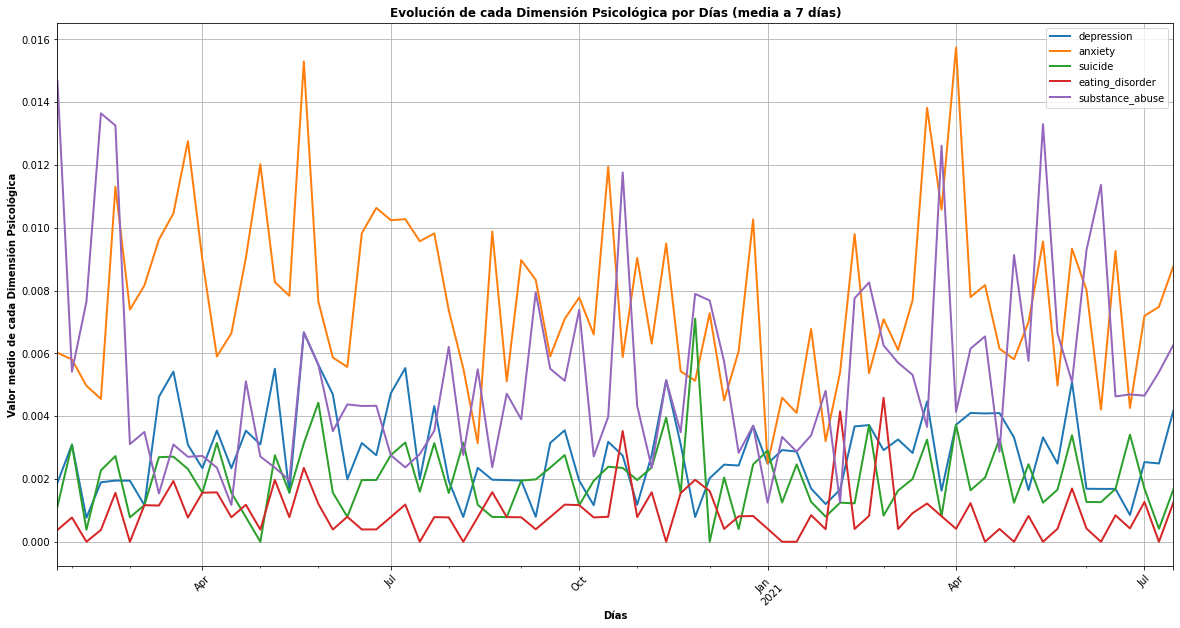

In [65]:
# Graficamos
ax = df_jan2020_jul2021_us_reddit_by_weeks[
    [
        'depression',
        'anxiety',
        'suicide',
        'eating_disorder',
        'substance_abuse' 
    ]
].plot(
    figsize=(20, 10),
    kind="line",
    rot=45,
    linewidth=2)

ax.grid()

# Añadimos estilo a la gráfica
ax.set_title(
    "Evolución de cada Dimensión Psicológica por Días (media a 7 días)", 
    weight='bold'
)
ax.set_xlabel(
    "Días", 
    weight='bold'
)
ax.set_ylabel(
    "Valor medio de cada Dimensión Psicológica", 
    weight='bold'
)


Como se puede ver, es díficil extraer conclusiones útiles a partir de esta gráfica ya que los datos están bastante entremezclados. Sin embargo, se pueden ver algunas cosas en común con el anális que llevamos a cabo con el dataset de tweets. Estas cosas en común son que el tema más hablado, en general, a lo largo de la pandemia es la **ansiedad** mientras que el menos hablado vuelven a ser los **trastornos de la conducta alimentaria**. Sin embargo, en este dataset de comentarios extraídos de Reddit el abuso de sustancias tiene una importancia mayor que en el dataset de tweets previo.

Para terminar, mostraré la gráfica anterior junto con **la curva con la incidencia acumulada a 7 días** (*7-Day Moving Avg*) para extraer las conclusiones finales:

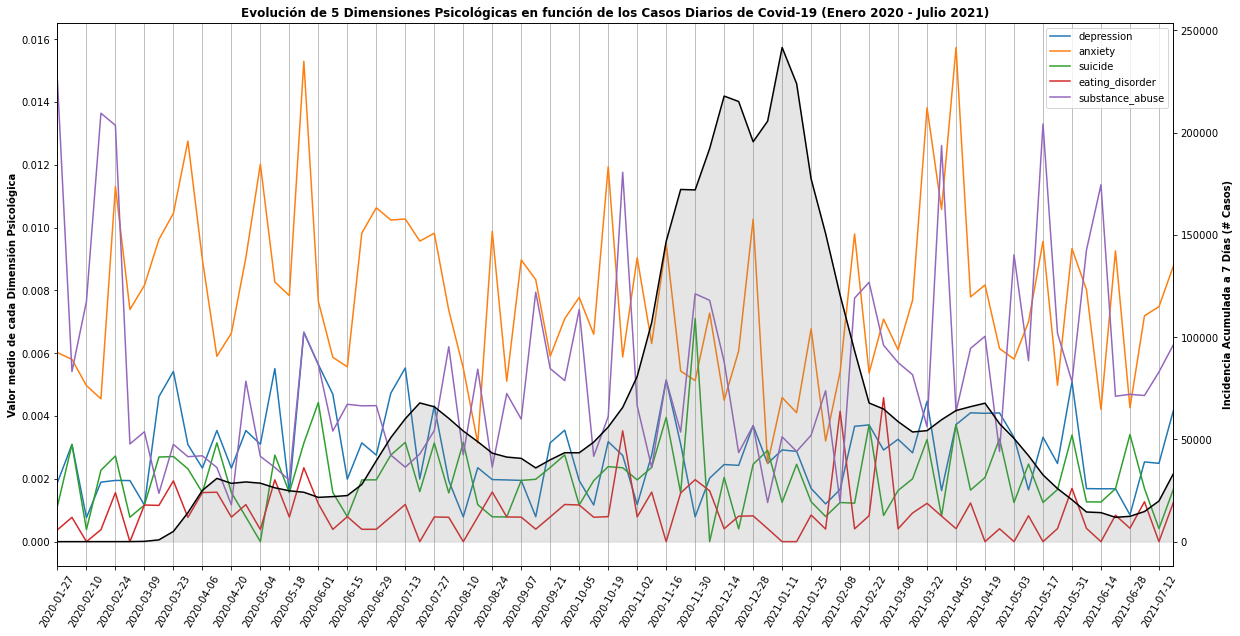

In [85]:
df_daily_case_trends_us = pd.read_csv(
    path_to_data + '/' + 'data_table_for_daily_case_trends__the_united_states.csv',
    usecols=['Date','7-Day Moving Avg'],
    dtype={'Date': str, '7-Day Moving Avg': int}
)

# Formateamos el DataFrame con los datos sobre los casos de covid
df_daily_case_trends_us['datetime'] = pd.to_datetime(df_daily_case_trends_us['Date'])
df_daily_case_trends_us.drop(columns='Date', inplace=True)

# Agrupamos a nivel de semana los casos de covid
df_daily_case_trends_us_by_weeks = df_daily_case_trends_us.resample(rule='W-MON', on='datetime')

# Calculamos la media de los valores para cada semana
df_daily_case_trends_us_by_weeks = df_daily_case_trends_us_by_weeks.agg({'7-Day Moving Avg': 'mean'})

# Definimos el primer y el último día para el que tenemos datos de sentimientos y de covid
start_date = max(df_jan2020_jul2021_us_reddit_by_weeks.first_valid_index(), df_daily_case_trends_us_by_weeks.first_valid_index())
end_date = min(df_jan2020_jul2021_us_reddit_by_weeks.last_valid_index(), df_daily_case_trends_us_by_weeks.last_valid_index())

# Eliminamos los días que queden fuera de este rango
df_jan2020_jul2021_us_reddit_by_weeks = df_jan2020_jul2021_us_reddit_by_weeks[df_jan2020_jul2021_us_reddit_by_weeks.index >= start_date]
df_jan2020_jul2021_us_reddit_by_weeks = df_jan2020_jul2021_us_reddit_by_weeks[df_jan2020_jul2021_us_reddit_by_weeks.index <= end_date]
df_daily_case_trends_us_by_weeks = df_daily_case_trends_us_by_weeks[df_daily_case_trends_us_by_weeks.index >= start_date]
df_daily_case_trends_us_by_weeks = df_daily_case_trends_us_by_weeks[df_daily_case_trends_us_by_weeks.index <= end_date]

def grap_dimensions_and_covid():
    # Definimos el número de semanas a representar
    n_weeks = df_jan2020_jul2021_us_reddit_by_weeks.shape[0]

    # Definimos los valores que queremos representar en cada eje
    x = np.arange(0, n_weeks, 1)
    y_ax1 = df_jan2020_jul2021_us_reddit_by_weeks[
        [
            'depression',
            'anxiety',
            'suicide',
            'eating_disorder',
            'substance_abuse'
        ]
    ]
    y_ax2 = df_daily_case_trends_us_by_weeks['7-Day Moving Avg']

    # Representamos los datos de sentimientos
    fig, ax1 = plt.subplots(figsize=(20, 10))
    ax1.plot(x, y_ax1)
    ax1.legend(
        [
            'depression', 
            'anxiety', 
            'suicide',
            'eating_disorder', 
            'substance_abuse'
        ], 
        loc='upper right')
    ax1.xaxis.grid(True)
    ax1.set_xlim(x.min(), x.max())

    # Definimos los xticks a representar
    xticks = np.arange(0, n_weeks, 2)
    xticks_labels = df_jan2020_jul2021_us_reddit_by_weeks.index.astype(str).to_frame().iloc[xticks]

    # Añadimos estilo al eje x
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xticks_labels.datetime, rotation=60)

    # Instanciamos un segundo ax que comparte el eje x con el anterior
    ax2 = ax1.twinx()

    # Representamos los datos de covid
    ax2.plot(x, y_ax2, color='black')
    ax2.fill_between(x, y_ax2, color='gray', alpha=0.2)

    # Añadimos texto a la gráfica
    ax1.set_title(
        'Evolución de 5 Dimensiones Psicológicas en función de los Casos Diarios de Covid-19 (Enero 2020 - Julio 2021)',
        weight='bold'
    )
    ax1.set_ylabel(
        'Valor medio de cada Dimensión Psicológica',
        weight='bold'
    )
    ax2.set_ylabel(
        'Incidencia Acumulada a 7 Días (# Casos)',
        weight='bold'
    )

grap_dimensions_and_covid()


Como se puede ver en la gráfica superior no es fácil extraer información útil entre los valores devueltos por la librería `Empath` para cada una de las 5 dimensiones psicológicas con las que trabajamos en relación con los casos de covid-19. Como ya dije antes, esto se debe a que los datos para las 5 dimensiones psicológicas con las que trabajamos tienen cambios de tendencia demasiado bruscos entre semanas. 

En mi opinión, llevar a cabo el análisis a partir de comentarios de Reddit **sí** que es posible y puede proporcionar información adicional al análisis realizado a partir de los tweets. Sin embargo, para esto habría que extraer un dataset mucho mayor que el que fue extraído en esta práctica. A pesar de esto, queda visto que sí es posible de llevar a cabo el análisis y también la forma de extraer los tweets. Para obtener un número mayor de comentarios, se tendría que modificar el código para reducir la longitud (en días) de los intervalos usados para obtener los comentarios y también añadir la opción de obtener más de 500 comentarios en cada intervalo, aunque esto nos podría llevar a obtener comentarios duplicados, que habría que filtrar.